In [1]:
from model import *
from func import *

import copy
import time
from time import perf_counter as pc

# Setting the seed
seed = 2022
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

/home/yang/apps/anaconda3/envs/epiformer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### load parameters

In [2]:
path2model = "../models/human.25k.multi.30way.4gpu4batch32accum11atten8head1152embed.model-1682666429.best_loss.pth.tar"

region4pred = "chr10:80426429-80517820" # TSPAN14
region2peak = "chr10:80491485-80492198" # peak

outprfx = "../muta/human.25k.multi.30way.4gpu4batch32accum11atten8head1152embed.model-1682666429.best_loss"

In [3]:
seq_len = 98304
bin_size = 128

species = "hg38"
path2dir = "../"

index = 3
path2trg = "../datasets/human_wigs.txt"
trgfiles = pd.read_csv(path2trg, delimiter = "\t")
celltype_list = trgfiles['identifier']
celltype_labels = celltype_list[index]

path2seqcons = ''.join([path2dir, "/genome/", species, ".phastCons.bw"])
if os.path.isfile(path2seqcons) is not True:
    path2seqcons = None
path2fasta = ''.join([path2dir, "/genome/", species, ".fa"])

### load model 

In [4]:
checkpoint = torch.load(path2model)
print("current model corr: ", checkpoint['current_model_corr'])
print("current valid corr: ", checkpoint['current_valid_corr'])
print("current model loss: ", checkpoint['current_model_loss'])
print("current valid loss: ", checkpoint['current_valid_loss'])

current model corr:  0.7509080171585083
current valid corr:  0.5842358469963074
current model loss:  0.33762448439721227
current valid loss:  0.5106442114329431


In [5]:
# Model hyperparameters
seq_len = checkpoint['param']['seq_len']
bin_size = checkpoint['param']['bin_size']
num_cnn_layer = checkpoint['param']['num_cnn_layer']
max_len = checkpoint['param']['max_len']
add_positional_encoding = checkpoint['param']['add_positional_encoding']
embed_size = checkpoint['param']['embed_size']
num_heads = checkpoint['param']['num_heads']
att_dropout = checkpoint['param']['att_dropout']
dim_feedforward = checkpoint['param']['dim_feedforward']
enc_dropout = checkpoint['param']['enc_dropout']
batch_first = checkpoint['param']['batch_first']
num_encoder_layers = checkpoint['param']['num_encoder_layers']
crop_size = checkpoint['param']['crop_size']
ptw_dropout = checkpoint['param']['ptw_dropout']
multiout_dim = checkpoint['param']['multiout_dim']
if_cons = checkpoint['param']['if_cons']
if_augment = checkpoint['param']['if_augment']
penalty = checkpoint['param']['penalty']

In [6]:
model = SelfTrans_signalOUT(
                  seq_len,
                  bin_size,
                  num_cnn_layer,
                  max_len,
                  add_positional_encoding,
                  embed_size,
                  num_heads,
                  att_dropout,
                  dim_feedforward,
                  enc_dropout,
                  batch_first,
                  num_encoder_layers,
                  ptw_dropout,
                  multiout_dim #recycle_count
                 )

load_checkpoint(checkpoint, model) # load state_dict to model
model = model.cpu()

=> loading checkpoint


### extract data

In [7]:
data = extract_data(region4pred,
                 path2trg,
                 path2fasta,
                 path2seqcons,
                 seq_len,
                 bin_size
                )

inputs, seqcons, targets = data['seq'], data['seqcons'], data['signal']
inputs, seqcons, targets = torch.tensor(inputs), torch.tensor(seqcons), torch.tensor(targets)
inputs = inputs.unsqueeze(0)
inputs = inputs.float()
seqcons = seqcons.unsqueeze(0)
seqcons = seqcons.float()
targets = targets.unsqueeze(0)

targets = targets[:, index, :].unsqueeze(1)

chr10 80422972 80521276


### predict and plot signals

In [8]:
if if_cons:
    inputs = inputs * torch.exp(seqcons)

# testing
torch.manual_seed(2022)
outs = model.forward(inputs)

if index:
    outs = outs[:,index,:].unsqueeze(1)

if crop_size > 0:
    crop_seq_size = targets.shape[2] - (crop_size * 2)
    targets = center_crop(targets, targets.shape[1], crop_seq_size)
    outs = center_crop(outs, outs.shape[1], crop_seq_size)
    
# calculate statistics
corr = metric(torch.flatten(torch.log2(outs+1), start_dim=1),
              torch.flatten(torch.log2(targets+1), start_dim=1)) # log2 pcc flatten

# output
corr = float(np.mean(corr.cpu().detach().numpy()))
print('Predicting...')
print('Model_Corr: {:.4f}'.format(corr))

Predicting...
Model_Corr: 0.7491


<Figure size 432x144 with 0 Axes>

<Figure size 1296x144 with 0 Axes>

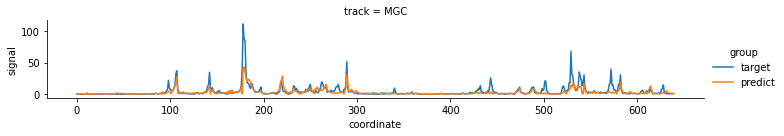

<Figure size 432x288 with 0 Axes>

In [9]:
# plotting 
plot_targets = targets.squeeze(0).detach().numpy()
plot_outs = outs.squeeze(0).detach().numpy()

fig = plt.figure(figsize=(6, 2))
plotone_pred_rawsignal(plot_targets, plot_outs, celltype_labels)
plt.savefig(outprfx + '.' + species + '.' + region4pred + '.' + 'pred_rawsignals.pdf')

<Figure size 432x144 with 0 Axes>

<Figure size 1296x144 with 0 Axes>

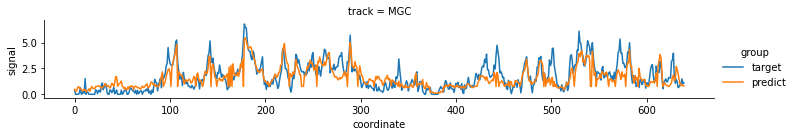

<Figure size 432x288 with 0 Axes>

In [10]:
fig = plt.figure(figsize=(6, 2))
plotone_pred_log2signal(plot_targets, plot_outs, celltype_labels)
plt.savefig(outprfx + '.' + species + '.' + region4pred + '.' + 'pred_log2signals.pdf')

In [11]:
# output
outfile = '.'.join([outprfx, species, region4pred, "true_signals.tsv"])
np.savetxt(outfile, plot_targets)

outfile = '.'.join([outprfx, species, region4pred, "pred_signals.tsv"])
np.savetxt(outfile, plot_outs)

### predict on mutagenesis

In [12]:
acgt = ['A','C','G','T']

In [13]:
def get_ovlp_index(pred_interval, peak_interval, bin_size, crop_size):
  pred_interval_bins = BedTool().window_maker(b=pred_interval, w=bin_size)
  # overlap with region
  region_ovlp = pred_interval_bins.intersect(peak_interval, wao=True)
  region_ovlpdf = pd.read_table(region_ovlp.fn, names=['chrom', 'start', 'stop', 'chr', 'begin', 'end', 'score'])
  region_ovlp_idx = region_ovlpdf.index[region_ovlpdf['chr'] != "."].tolist()
  region_ovlp_idx = [x-crop_size for x in region_ovlp_idx]
  return region_ovlp_idx

In [14]:
def get_ref_nucleotide(one_hot_array):
  acgt2num = {0: 'A',
              1: 'C',
              2: 'G',
              3: 'T'}

  idx = int(np.where(one_hot_array == 1)[0])
  out = acgt2num[idx]
  return out

In [15]:
def seq2onehot(seq):
    acgt2num = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    seq = seq.upper() # uppercase
    h = 4
    w = len(seq)
    mat = np.zeros((h, w), dtype=int)  # True or false in mat

    for i in range(w):
        if seq[i] != 'N':
            mat[acgt2num[seq[i]], i] = 1.
    return mat

In [16]:
''' get region for prediction extend from center '''
region4pred_str = region4pred.strip().replace(':', ' ').replace('-', ' ').split()
region4pred_chrom = region4pred_str[0]
region_len = int(region4pred_str[2]) - int(region4pred_str[1])
region_diff = seq_len - region_len
region_flank = int(region_diff/2)
if region_diff % 2 == 1:
    region4pred_start = int(region4pred_str[1]) - region_flank - 1
    region4pred_end = int(region4pred_str[2]) + region_flank
else:
    region4pred_start = int(region4pred_str[1]) - region_flank
    region4pred_end = int(region4pred_str[2]) + region_flank
region4pred_str = ' '.join([region4pred_chrom, str(region4pred_start), str(region4pred_end)])
region4pred_interval = BedTool(region4pred_str, from_string=True)
print("predict region: ", region4pred_str)
    
'''get peak loci'''
region2peak_str = region2peak.strip().replace(':', ' ').replace('-', ' ').split()
region2peak_chrom = region2peak_str[0]
region2peak_start = int(region2peak_str[1])
region2peak_end = int(region2peak_str[2])
region2peak_str = ' '.join([region2peak_chrom, str(region2peak_start), str(region2peak_end)])
region2peak_interval = BedTool(region2peak_str, from_string=True)
print("measure region: ", region2peak_str)

'''get mutagenesis index'''
start_seq_index = region2peak_start - region4pred_start
end_seq_index = region2peak_end - region4pred_start
print("mutagenesis from ", start_seq_index, " to ", end_seq_index)

'''get overlapped bins index'''
ovlp_bin_index = get_ovlp_index(region4pred_interval, region2peak_interval, bin_size, crop_size)
#ovlp_bin_index = get_bin_index(region4pred_start, bin_size, region2peak_start, region2peak_end, crop_size = crop_size)
start_ovlp_bin_index = ovlp_bin_index[0]  
end_ovlp_bin_index = ovlp_bin_index[-1] + 1
print("measure from bin ", start_ovlp_bin_index, " to ", end_ovlp_bin_index)

predict region:  chr10 80422972 80521276
measure region:  chr10 80491485 80492198
mutagenesis from  68513  to  69226
measure from bin  471  to  477


In [17]:
data = extract_data(region4pred,
                 path2trg,
                 path2fasta,
                 path2seqcons,
                 seq_len,
                 bin_size
                )

inputs, seqcons, targets = data['seq'], data['seqcons'], data['signal']

chr10 80422972 80521276


In [19]:
ref_inputs, ref_seqcons = torch.tensor(inputs), torch.tensor(seqcons)
ref_inputs = ref_inputs.unsqueeze(0)
ref_inputs = ref_inputs.float()
ref_seqcons = ref_seqcons.unsqueeze(0)
ref_seqcons = ref_seqcons.float()

if if_cons:
    ref_inputs = ref_inputs * torch.exp(ref_seqcons)

# testing
torch.manual_seed(2022)
ref_outs = model.forward(ref_inputs)

if index:
    ref_outs = ref_outs[:,index,:].unsqueeze(1)

if crop_size > 0:
    crop_seq_size = ref_outs.shape[2] - (crop_size * 2)
    ref_outs = center_crop(ref_outs, ref_outs.shape[1], crop_seq_size)

ref_pred_signal = ref_outs[:, :, start_ovlp_bin_index:end_ovlp_bin_index]
ref_pred_signal_sum = torch.sum(ref_pred_signal) 
#ref_pred_signal_max = max(torch.flatten(ref_pred_signal), key=abs) 

In [20]:
torch.flatten(ref_pred_signal)

tensor([3.6499, 4.0481, 6.7909, 9.3772, 4.8978, 2.5694],
       grad_fn=<ReshapeAliasBackward0>)

In [21]:
ref_inputs[:,:,68814:68818]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [1.1388, 1.0640, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.0704, 1.1074]]])

In [22]:
since = time.time()

acgt = ['A','C','G','T']

i_list = []
nuc_list = []
grp_list = []
alt2ref_list = []

for i in range(start_seq_index, end_seq_index+1):
#for i in range(68814, 68818):
    i_list.append(i-start_seq_index)
    nuc = inputs[:,i]
    #print(nuc)
    ref_nuc = get_ref_nucleotide(nuc)
    nuc_list.append(ref_nuc)
    grp_list.append("ref")
    alt2ref_list.append(0)
    
    alt_nuc = set(acgt) - set(ref_nuc)
    alt_nuc = list(alt_nuc)
    for alt in alt_nuc:
        #print(alt)
        i_list.append(i-start_seq_index)
        nuc_list.append(alt)
        grp_list.append("alt")
        alt_onehot = np.ravel(seq2onehot(alt))
        alt_input = copy.deepcopy(inputs)
        alt_input[:,i] = alt_onehot # mutagenesis
        
        alt_input = torch.tensor(alt_input)
        alt_input = alt_input.unsqueeze(0)
        alt_input = alt_input.float()
        
        if if_cons:
            alt_input = alt_input * torch.exp(ref_seqcons)
        
        torch.manual_seed(2022)
        alt_outs = model.forward(alt_input) # test on mutagenesis
        #print(alt_outs.shape)
        
        if index:
            alt_outs = alt_outs[:,index,:].unsqueeze(1)

        if crop_size > 0:
            crop_seq_size = alt_outs.shape[2] - (crop_size * 2)
            alt_outs = center_crop(alt_outs, alt_outs.shape[1], crop_seq_size)
        
        '''get diff'''
        alt_pred_signal = alt_outs[:, :, start_ovlp_bin_index:end_ovlp_bin_index]
        #print(torch.flatten(alt_pred_signal))
        
        alt_pred_signal_sum = torch.sum(alt_pred_signal) 
        alt2ref = alt_pred_signal_sum - ref_pred_signal_sum
        alt2ref_list.append(float(alt2ref))
        #print(alt2ref)
        
        #alt2ref = torch.flatten(alt_pred_signal) - torch.flatten(ref_pred_signal)
        #alt2ref_max = max(alt2ref, key=abs)
        #alt2ref_list.append(float(alt2ref_max))
        #print(alt2ref_max)
        
time_elapsed = time.time() - since

print('-' * 10)
print('Test on mutagenesis complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

----------
Test on mutagenesis complete in 36m 43s


In [23]:
ref_pred_signal

tensor([[[3.6499, 4.0481, 6.7909, 9.3772, 4.8978, 2.5694]]],
       grad_fn=<SliceBackward0>)

In [24]:
alt_pred_signal

tensor([[[3.6457, 4.0376, 6.7840, 9.3668, 4.7633, 2.5273]]],
       grad_fn=<SliceBackward0>)

In [25]:
res = pd.DataFrame(dict(index = i_list,
                        nuc = nuc_list,
                        group = grp_list,
                        alt2ref = alt2ref_list
                       )
                  )

In [26]:
res

,index,nuc,group,alt2ref
0,0,T,ref,0.000000
1,0,C,alt,-0.536224
2,0,G,alt,1.888809
3,0,A,alt,-0.149696
4,1,G,ref,0.000000
...,...,...,...,...
2851,712,A,alt,-0.014259
2852,713,T,ref,0.000000
2853,713,C,alt,-0.182705
2854,713,G,alt,-0.195827


In [ ]:
outprfx = "../muta/human.25k.multi.30way.4gpu4batch32accum11atten8head1152embed.model-1682666429.best_loss.pred_variant.rs7922621.peak"

In [27]:
OUT_NAME = outprfx + '.' + region2peak + ".muta_res.txt"
res.to_csv(OUT_NAME, sep="\t", header=True, index=False)

### predict on SNPs/variants

In [28]:
def plotone_refalt_rawsignal(refs, alts, labels, width=18, height=2, dpi=100):
    num_y = len(labels)
    num_x = refs.shape[1]

    x = [*range(0, num_x, 1)]

    coordinate = []
    signal = []
    group = []
    track = []

    coordinate.append(x) # for ref
    coordinate.append(x) # for alt
    signal.append(refs[0,])
    signal.append(alts[0,])
    group.append(["ref"] * num_x)
    group.append(["alt"] * num_x)
    track.append([labels] * num_x * 2)

    d = {'coordinate': np.concatenate(coordinate),
         'signal': np.concatenate(signal),
         'group' : np.concatenate(group),
         'track' : np.concatenate(track)}
    df = pd.DataFrame(data=d)

    plt.figure(figsize=(width, height))
    #sns.set_theme(style="ticks", font_scale=2)
    sns.relplot(x="coordinate", y="signal", hue="group",
            row="track", height=2, aspect=5,
            kind="line", estimator=None, data=df);
    #plt.show()

In [29]:
def plotone_diff_rawsignal(refs, alts, labels, width=18, height=2, dpi=100):
    num_y = len(labels)
    num_x = refs.shape[1]

    x = [*range(0, num_x, 1)]

    coordinate = []
    signal = []
    group = []
    track = []

    coordinate.append(x) # for alt-ref
    coordinate.append(x) # for ref-alt
    signal.append(alts[0,] - refs[0,])
    signal.append(refs[0,] - alts[0,])
    group.append(["alt-ref"] * num_x)
    group.append(["ref-alt"] * num_x)
    track.append([labels] * num_x * 2)

    d = {'coordinate': np.concatenate(coordinate),
         'signal': np.concatenate(signal),
         'group' : np.concatenate(group),
         'track' : np.concatenate(track)}
    df = pd.DataFrame(data=d)

    plt.figure(figsize=(width, height))
    #sns.set_theme(style="ticks", font_scale=2)
    sns.relplot(x="coordinate", y="signal", hue="group",
            row="track", height=2, aspect=5,
            kind="line", estimator=None, data=df);
    #plt.show()

In [30]:
region4pred = "chr10:80426429-80517820" # TSPAN14
region2peak = "chr10:80491485-80492198" # peak
coor2var = "chr10:80491788:C:A" # rs7922621

outprfx = "../muta/human.25k.multi.30way.4gpu4batch32accum11atten8head1152embed.model-1682666429.best_loss.pred_variant.rs7922621"

In [31]:
seq_len = 98304
bin_size = 128

species = "hg38"
path2dir = "../"

index = 3
path2trg = "../datasets/human_wigs.txt"
trgfiles = pd.read_csv(path2trg, delimiter = "\t")
celltype_list = trgfiles['identifier']
celltype_labels = celltype_list[index]

path2seqcons = ''.join([path2dir, "/genome/", species, ".phastCons.bw"])
if os.path.isfile(path2seqcons) is not True:
    path2seqcons = None
path2fasta = ''.join([path2dir, "/genome/", species, ".fa"])

In [32]:
''' get region for prediction extend from center '''
region4pred_str = region4pred.strip().replace(':', ' ').replace('-', ' ').split()
region4pred_chrom = region4pred_str[0]
region_len = int(region4pred_str[2]) - int(region4pred_str[1])
region_diff = seq_len - region_len
region_flank = int(region_diff/2)
if region_diff % 2 == 1:
    region4pred_start = int(region4pred_str[1]) - region_flank - 1
    region4pred_end = int(region4pred_str[2]) + region_flank
else:
    region4pred_start = int(region4pred_str[1]) - region_flank
    region4pred_end = int(region4pred_str[2]) + region_flank
region4pred_str = ' '.join([region4pred_chrom, str(region4pred_start), str(region4pred_end)])
region4pred_interval = BedTool(region4pred_str, from_string=True)
print("predict region: ", region4pred_str)

'''get peak loci'''
coor2var_str = coor2var.strip().replace(':', ' ').split()
coor2var_chrom = coor2var_str[0]
coor2var_start = int(coor2var_str[1]) -1
coor2var_end = int(coor2var_str[1])
refnuc=coor2var_str[2]
altnuc=coor2var_str[3]
print("ref:", refnuc, " alt:", altnuc)
coor2var_str = ' '.join([coor2var_chrom, str(coor2var_start), str(coor2var_end)])
coor2var_interval = BedTool(coor2var_str, from_string=True)
print("measure variant: ", coor2var_str)

'''get mutagenesis index'''
start_var_index = coor2var_start - region4pred_start
end_var_index = coor2var_end - region4pred_start
print("mutagenesis from ", start_var_index, " to ", end_var_index)

predict region:  chr10 80422972 80521276
ref: C  alt: A
measure variant:  chr10 80491787 80491788
mutagenesis from  68815  to  68816


In [33]:
data = extract_data(region4pred,
                 path2trg,
                 path2fasta,
                 path2seqcons,
                 seq_len,
                 bin_size
                )

inputs, seqcons, targets = data['seq'], data['seqcons'], data['signal']

seqcons = torch.tensor(seqcons)
seqcons = seqcons.unsqueeze(0)
seqcons = seqcons.float()

# ref
ref_inputs = torch.tensor(inputs)
ref_inputs = ref_inputs.unsqueeze(0)
ref_inputs = ref_inputs.float()

# alt
alt_input = copy.deepcopy(inputs)
alt_onehot = np.ravel(seq2onehot(altnuc))
alt_input[:,start_var_index] = alt_onehot # mutagenesis

alt_input = torch.tensor(alt_input)
alt_input = alt_input.unsqueeze(0)
alt_input = alt_input.float()

if if_cons:
    ref_inputs = ref_inputs * torch.exp(seqcons)
    alt_input = alt_input * torch.exp(seqcons)

chr10 80422972 80521276


In [34]:
# predicting ref
torch.manual_seed(2022)
ref_outs = model.forward(ref_inputs)

In [35]:
# predicting alt
torch.manual_seed(2022)
alt_outs = model.forward(alt_input)

In [36]:
if index:
    ref_outs = ref_outs[:,index,:].unsqueeze(1)
    alt_outs = alt_outs[:,index,:].unsqueeze(1)

if crop_size > 0:
    crop_seq_size = ref_outs.shape[2] - (crop_size * 2)
    ref_outs = center_crop(ref_outs, ref_outs.shape[1], crop_seq_size)
    alt_outs = center_crop(alt_outs, alt_outs.shape[1], crop_seq_size)

In [37]:
ref_outs[:, :, 471:477]

tensor([[[3.6499, 4.0481, 6.7909, 9.3772, 4.8978, 2.5694]]],
       grad_fn=<SliceBackward0>)

In [38]:
alt_outs[:, :, 471:477]

tensor([[[3.1806, 3.5086, 5.1252, 8.2682, 4.4581, 2.3312]]],
       grad_fn=<SliceBackward0>)

In [39]:
plot_ref = ref_outs.squeeze(0).detach().numpy()
plot_alt = alt_outs.squeeze(0).detach().numpy()

<Figure size 432x144 with 0 Axes>

<Figure size 1296x144 with 0 Axes>

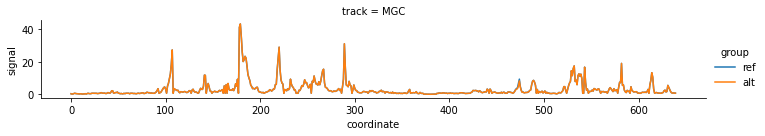

In [40]:
fig = plt.figure(figsize=(6, 2))
plotone_refalt_rawsignal(refs=plot_ref, 
                         alts=plot_alt, 
                         labels=celltype_labels)
plt.savefig(outprfx + '.' + species + '.' + region4pred + '.' + 'pred_refalt_rawsignal.pdf')

<Figure size 432x144 with 0 Axes>

<Figure size 1296x144 with 0 Axes>

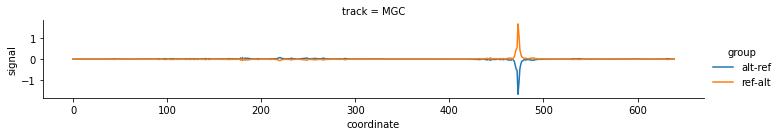

In [41]:
fig = plt.figure(figsize=(6, 2))
plotone_diff_rawsignal(refs=plot_ref, 
                         alts=plot_alt, 
                         labels=celltype_labels)
plt.savefig(outprfx + '.' + species + '.' + region4pred + '.' + 'pred_diff_rawsignal.pdf')